In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton
from datetime import datetime
import matplotlib.pyplot as plt


In [ ]:
def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

In [ ]:
#Parameters
K = 100
r = 0.05
T = 1
sigma = 0.3
S0 = np.arange(60, 140, 0.1)

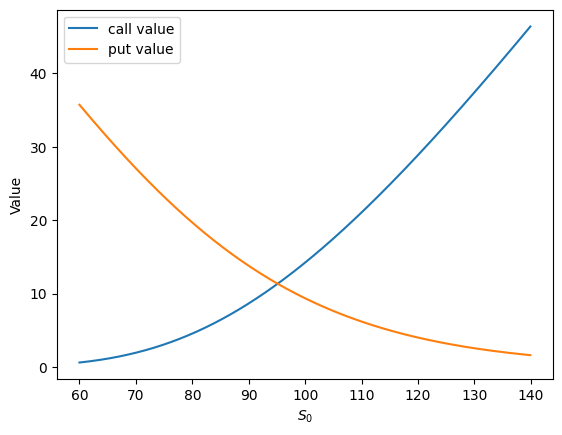

In [ ]:
call = [black_scholes(S, K, T, r, sigma, 'Call') for S in S0]
put = [black_scholes(S, K, T, r, sigma, 'put') for S in S0]
plt.plot(S0, call, label = 'call value')
plt.plot(S0, put, label = 'put value')
plt.xlabel('$S _0$')
plt.ylabel('Value')
plt.legend()

/tmp/ipython-input-6-2260909224.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


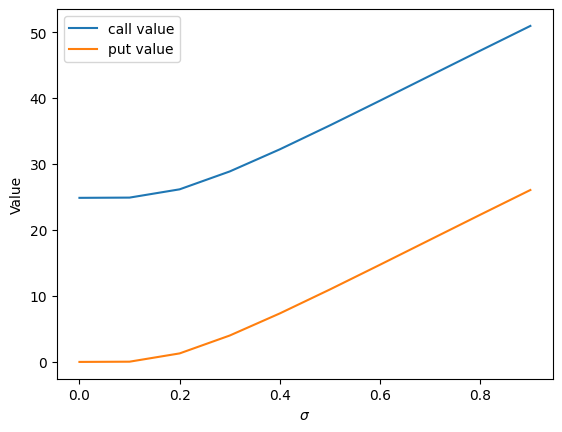

In [ ]:
#Parameters
K = 100
r = 0.05
T = 1
S = 120
Sigmas = np.arange(0, 1, 0.1)

call = [black_scholes(S, K, T, r, sigma, 'Call') for sigma in Sigmas]
put = [black_scholes(S, K, T, r, sigma, 'put') for sigma in Sigmas]
plt.plot(Sigmas, call, label = 'call value')
plt.plot(Sigmas, put, label = 'put value')
plt.xlabel('$\sigma$')
plt.ylabel('Value')
plt.legend()

/tmp/ipython-input-6-2260909224.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipython-input-6-2260909224.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


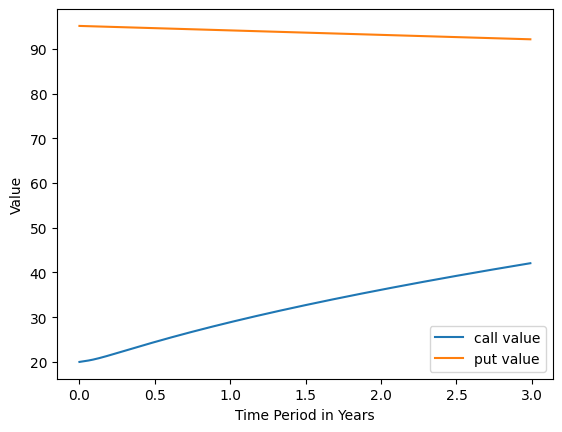

In [ ]:
#Parameters
K = 100
r = 0.05
S = 120
sigma = 0.3
Tm = np.arange(0, 3, 0.01)

call = [black_scholes(S, K, T, r, sigma, 'Call') for T in Tm]
put = [black_scholes(S, K, T, r, sigma, 'put') for S in Tm]
plt.plot(Tm, call, label = 'call value')
plt.plot(Tm, put, label = 'put value')
plt.xlabel('Time Period in Years')
plt.ylabel('Value')
plt.legend()

In [ ]:
# Implied volatility : https://www.youtube.com/watch?v=j9DrTHazR0w
def implied_volatility(S, K, T, r, market_price, option_type, sigma_guess=0.3):
    def price_diff(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return newton(price_diff, sigma_guess)
    except:
        return np.nan


In [ ]:
# Time to maturity
def calculate_time_to_maturity(current_date, expiration_date):
    current = datetime.strptime(current_date.split()[0], '%m/%d/%Y')
    expiry = datetime.strptime(expiration_date, '%m/%d/%Y')
    T = (expiry - current).days / 365.0
    return T if T > 0 else np.nan

In [ ]:
#https://www.kaggle.com/datasets/muhammadanas0716/tradyflow-options-trading
df = pd.read_csv("Trady Flow - Best Options Trade Ideas.csv")
df.head()

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,OI,Diff(%),ITM
0,6/17/2022 15:07,ISEE,Call,10/21/2022,10.0,9.54,5.05,7,360,183.60K,4.07K,4.71,0
1,6/17/2022 15:05,CVNA,Call,1/19/2024,60.0,23.52,4.60,7,634,310.66K,130,155.05,0
2,6/17/2022 14:51,PTLO,Put,2/17/2023,15.0,15.19,3.50,7,800,281.00K,0,1.39,0
3,6/17/2022 14:39,TWLO,Call,6/24/2022,86.0,84.51,2.95,5,722,198.80K,436,2.48,0
4,6/17/2022 13:56,ATUS,Put,9/16/2022,7.0,8.62,0.68,5,6.27K,501.84K,8.63K,23.13,0


In [ ]:
df['T'] = df.apply(lambda row: calculate_time_to_maturity(row['Time'], row['Exp']), axis=1)
df = df[df['T'].notna() & (df['T'] > 0)]
#Parameters
df['r'] = 0.02  # 2% risk-free rate
df['sigma'] = 0.3  # 30% volatility

/tmp/ipython-input-14-2849223543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r'] = 0.02  # 2% risk-free rate
/tmp/ipython-input-14-2849223543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sigma'] = 0.3  # 30% volatility


In [ ]:
# Calculate Black-Scholes prices
df['BS_Price'] = df.apply(
    lambda row: black_scholes(
        row['Spot'], row['Strike'], row['T'], row['r'], row['sigma'], row['C/P']
    ), axis=1
)

In [ ]:
# Calculate implied volatility
df['Implied_Vol'] = df.apply(
    lambda row: implied_volatility(
        row['Spot'], row['Strike'], row['T'], row['r'], row['BidAsk'], row['C/P']
    ), axis=1
)


In [ ]:
# Recalculate BS_Price with implied volatility
df['BS_Price_IV'] = df.apply(
    lambda row: black_scholes(
        row['Spot'], row['Strike'], row['T'], row['r'], row['Implied_Vol'], row['C/P']
    ) if not np.isnan(row['Implied_Vol']) else np.nan, axis=1
)

In [ ]:
# Compare prices
df['Price_Difference'] = df['BS_Price'] - df['BidAsk']
df['Percentage_Difference'] = (df['Price_Difference'] / df['BidAsk']) * 100

In [ ]:
print(df[['Sym', 'C/P', 'Strike', 'Spot', 'BidAsk', 'BS_Price', 'Implied_Vol', 'BS_Price_IV', 'Price_Difference', 'Percentage_Difference']].head(10))

    Sym   C/P  Strike   Spot  BidAsk  BS_Price  Implied_Vol  BS_Price_IV  \
0  ISEE  Call    10.0   9.54    5.05  0.505755     2.507423         5.05   
1  CVNA  Call    60.0  23.52    4.60  0.038644     0.898301         4.60   
2  PTLO   Put    15.0  15.19    3.50  1.279786     0.765660         3.50   
3  TWLO  Call    86.0  84.51    2.95  0.802049     0.771660         2.95   
4  ATUS   Put     7.0   8.62    0.68  0.040367     0.879363         0.68   
5    WE   Put     5.0   5.41    0.83  0.098775     1.208636         0.83   
6   FSR   Put     7.5   8.65    0.97  0.059419     1.122973         0.97   
7  PINS   Put    17.5  17.68    3.73  1.423998     0.738734         3.73   
8    ET  Call    10.0   9.84    1.53  1.543414     0.297219         1.53   
9   WFC  Call    40.0  38.31    6.15  5.567426     0.330655         6.15   

   Price_Difference  Percentage_Difference  
0         -4.544245             -89.985043  
1         -4.561356             -99.159912  
2         -2.220214         

In [ ]:
print("\nSummary Statistics:")
print(df[['Price_Difference', 'Percentage_Difference']].describe())


Summary Statistics:
       Price_Difference  Percentage_Difference
count       7797.000000            7797.000000
mean          -1.350378             -36.516316
std            3.256583              60.239745
min          -65.932291            -100.000000
25%           -2.357445             -78.011937
50%           -1.118809             -50.715564
75%           -0.238337             -11.291448
max           38.349047             647.389699


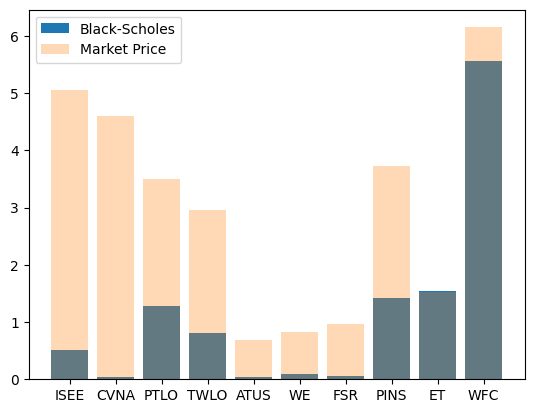

In [ ]:
# Sample code for visualization (not executed unless requested)
import matplotlib.pyplot as plt
subset = df.head(10)
plt.bar(subset['Sym'], subset['BS_Price'], alpha=1, label='Black-Scholes')
plt.bar(subset['Sym'], subset['BidAsk'], alpha=0.3, label='Market Price')
plt.legend()
plt.show()